In [1]:
import os
import numpy as np
import torch
from PIL import Image

import cv2 as cv

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import random
import time

In [2]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [3]:
trans = get_transform(False)

In [4]:
trans

In [5]:
imgPath = "TestImgs"

In [6]:
imgDir = os.listdir(imgPath)

In [7]:
imgDir

['Bad - 20201219140916115.png',
 'Bad - 20201219140944549.png',
 'Bad - 20201219140953798.png',
 'Bad - 20201219140959196.png',
 'Bad - 20201219141003814.png',
 'Bad - 20201219141013236.png',
 'Bad - 20201219141014204.png',
 'Bad - 20201219141019404.png',
 'Bad - 20201219141024032.png',
 'Bad - 20201219141032884.png',
 'Bad - 20201219141042887.png',
 'Bad - 20201219141046934.png',
 'Bad - 20201219141056551.png',
 'Bad - 20201219141100980.png',
 'Bad - 20201219141104845.png',
 'Bad - 20201219141109657.png',
 'Bad - 20201219141113719.png',
 'Bad - 20201219141118156.png',
 'Bad - 20201219141128933.png',
 'Bad - 20201219141132616.png',
 'Bad - 20201219141136476.png',
 'Bad - 20201219141141296.png',
 'Bad - 20201219141204747.png',
 'Bad - 20201219141212078.png',
 'Bad - 20201219141215756.png',
 'Bad - 20201219141226331.png',
 'Bad - 20201219141229986.png',
 'Bad - 20201219141233657.png',
 'Bad - 20201219141238474.png',
 'Bad - 20201219141241945.png',
 'Bad - 20201219141253302.png',
 'Bad - 

In [11]:
imgs = []
labs = []

In [10]:
for im in imgDir:
    imgR = cv.imread(os.path.join(imgPath, im))
    imgR = cv.cvtColor(imgR, cv.COLOR_BGR2RGB)
    
    imgs.append(imgR)
    
    if("B" in im):
        labs.append(2)
    else:
        labs.append(1)

In [9]:
imgPathC ="cTest\Good"
imgCDir = os.listdir(imgPathC)
for im in imgCDir:
    imgR = cv.imread(os.path.join(imgPathC, im))
    imgR = cv.cvtColor(imgR, cv.COLOR_RGB2GRAY)
    
    imgs.append(imgR)
    
    if("B" in im):
        labs.append(2)
    else:
        labs.append(1)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'cTest\\Good'

In [12]:
imgPathC ="test\Good"
imgCDir = os.listdir(imgPathC)
for im in imgCDir:
    imgR = cv.imread(os.path.join(imgPathC, im))
    imgR = cv.cvtColor(imgR, cv.COLOR_BGR2RGB)
    
    h,w,c = imgR.shape
    
    img = np.zeros((1232,1624,3), dtype=np.uint8)
    img[0:h,0:w,:] = imgR
    
    imgs.append(img)
    
    if("B" in im):
        labs.append(2)
    else:
        labs.append(1)

In [13]:
imgPathC ="test\Bad"
imgCDir = os.listdir(imgPathC)
for im in imgCDir:
    imgR = cv.imread(os.path.join(imgPathC, im))
    imgR = cv.cvtColor(imgR, cv.COLOR_BGR2RGB)
    
    h,w,c = imgR.shape
    
    img = np.zeros((1232,1624,3), dtype=np.uint8)
    img[0:h,0:w,:] = imgR
    
    imgs.append(img)
    
    if("B" in im):
        labs.append(2)
    else:
        labs.append(1)

In [6]:
imgPathC ="TestImgsColor"
imgCDir = os.listdir(imgPathC)
for im in imgCDir:
    imgR = cv.imread(os.path.join(imgPathC, im))
    imgR = cv.cvtColor(imgR, cv.COLOR_BGR2RGB)
    
    imgs.append(imgR)
    
    if("B" in im):
        labs.append(2)
    else:
        labs.append(1)

In [12]:
torch.cuda.empty_cache()

In [14]:
model = torch.load("modelCN4.pt")

In [12]:
tImg,t = trans(imgs[0], dict())

In [15]:
with torch.no_grad():
    matrix = [[0, 0], [0, 0]]
    masks = []
    t1 = time.time()
    for i in range(len(imgs)):
        tImg, t = trans(imgs[i], dict())
        tImg = tImg.to('cuda')

        pred = model([tImg])[0]
        maxInd = 0
        score = pred["scores"][maxInd]
        label = pred["labels"][maxInd]
        mask = pred["masks"][maxInd]
        masks.append(mask)
        #if(labs[i] != label):
        #print(f"GT: {labs[i]} Predicted: {label}")
        #print(pred["labels"].cpu())
        #print(pred["scores"].cpu())

        matrix[labs[i]-1][label-1] += 1
    t2 = time.time()
    print(f"Time Elapsed: {(t2-t1)/len(imgs):.4}")

Time Elapsed: 0.06793


In [16]:
matrix

[[232, 13], [14, 156]]

In [17]:
print("Confusion Matrix")
print("            | Predicted Good | Predicted Bad ")
print(f"Actual Good | {matrix[0][0]:14} | {matrix[0][1]:13}")
print(f"Actual Bad  | {matrix[1][0]:14} | {matrix[1][1]:13}")

Confusion Matrix
            | Predicted Good | Predicted Bad 
Actual Good |            232 |            13
Actual Bad  |             14 |           156


In [18]:
print(f"Correct Precentage: {100*(matrix[0][0]+matrix[1][1])/len(imgs)}")

Correct Precentage: 93.49397590361446


In [36]:
for i in range(len(imgCDir)):
    m = masks[i].detach().numpy().squeeze()
    r,m = cv.threshold(m, 0.3, 255, cv.THRESH_BINARY)
    z = np.zeros_like(m, dtype=np.uint8)
    if(labs[i] == 1):
        m = np.stack([m,z,z], axis=-1)
    elif(labs[i] == 2):
        m = np.stack([z,z,m], axis=-1)
    cv.imwrite(imgCDir[i][:-4]+"_Mask.png", m)

In [33]:
imgCDir[0][:-4] + "_Mask.png"

'Bad - 20201219152756652_Mask.png'

In [21]:
m1 = masks[0]

In [25]:
m1 = m1.detach().numpy()

<IPython.core.display.Javascript object>


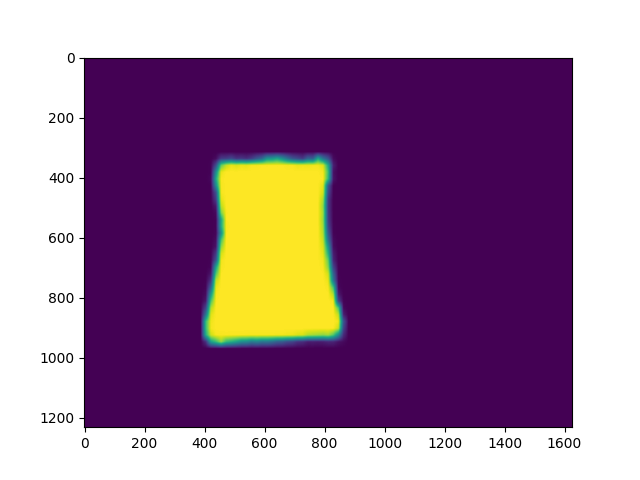

In [27]:
plt.figure()
plt.imshow(m1.squeeze())

<IPython.core.display.Javascript object>


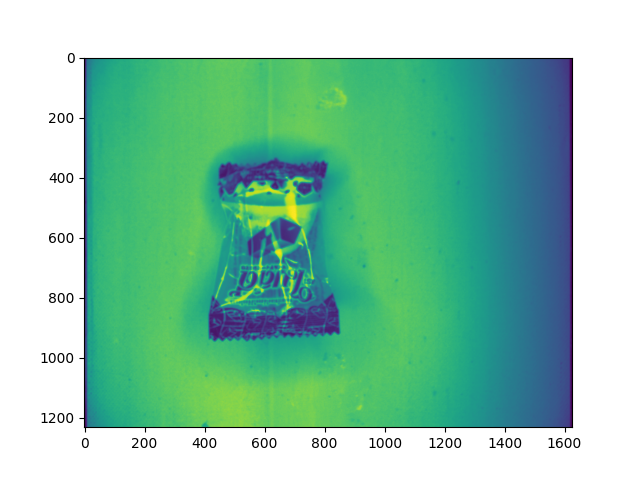

In [28]:
plt.figure()
plt.imshow(imgs[0])

In [16]:
tImg = tImg.to('cuda')

In [17]:
model([tImg])

[{'boxes': tensor([[173.2521, 246.2334, 759.8327, 981.8532],
          [177.3929, 211.6623, 766.0521, 997.4990]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 2], device='cuda:0'),
  'scores': tensor([0.8544, 0.4636], device='cuda:0', grad_fn=<IndexBackward>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
         grad_fn=<UnsqueezeBackward0>)}]

In [19]:
imgs[0].shape

(1236, 1626, 3)